In [41]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import requests
import json
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import hvplot.pandas

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import alpaca_trade_api as tradeapi
import datetime
from dateutil.relativedelta import relativedelta

import technical_indicators as ti
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pickle

import p2_FMP_Requests as fmp

# Load the environment variables from the .env file
load_dotenv()

fmp_apikey = os.getenv("FMP_API_KEY")
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version = "v2")

## Initializations

In [42]:
ticker = 'NVDA'

filepath = ('./Resources/' + str(ticker) +'_data.csv') # daily data
ticker = 'NVDA'
num_periods = "1000"
timeframe = "1Day"
short_window = 4
long_window = 20
CCI_period = 20
EVM_period = 14
SMA_EWMA_period_list = [short_window,long_window,100,200]
ROC_period = 5
BBands_period = 50
FI_period = 1


___
## Get Data

In [43]:
# Get data from file
data = pd.read_csv(filepath, index_col='date', parse_dates=True, infer_datetime_format=True)
data

,open,high,low,close,volume,vwap
date,,,,,,
2018-10-11,60.542499,61.889999,58.564999,58.782501,72543600.0,59.58779
2018-10-12,61.377499,62.384998,59.912498,61.634998,60823600.0,61.14512
2018-10-15,61.500000,61.500000,58.834999,58.845001,44976000.0,59.56845
2018-10-16,59.982498,61.570000,59.485001,61.457501,40871200.0,60.67227
2018-10-17,62.084999,62.470001,60.270001,60.764999,32966800.0,61.00496
...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000


In [44]:
# ## Get live data from FinancialModellingPrep.com
# data_hist_price_response = fmp.get_historial_daily_stock_price_last_x_days(ticker, num_days, fmp_apikey)
# data_hist_price_df = pd.DataFrame(data_hist_price_response['historical']).drop('label', axis=1).set_index('date')

# data = data_hist_price_df.sort_index(ascending=True)
# data = data.drop(['unadjustedVolume', 'adjClose', 'change', 'changePercent', 'changeOverTime'], axis=1)

# data.to_csv(filepath)
# data

In [45]:
## Get live data from Alpaca Markets

# # Set start and end dates
# today = datetime.datetime.today().date()
# back = today - relativedelta(years=10)
# print(today,back)

# start_date = pd.Timestamp(back, tz="America/New_York").isoformat()
# end_date = pd.Timestamp(today, tz="America/New_York").isoformat()
# print(start_date, end_date)

# data = alpaca.get_bars(
#     ticker,
#     timeframe,
#     start=start_date,
#     end=end_date
# ).df

# data.to_csv(filepath)


___
## Use Technical Indicators to generate features

In [46]:
# Add technical indicators to dataframe
data = ti.CCI(data, CCI_period) # Feature - CCI (Commodity Channel Index)
data = ti.EVM(data, EVM_period) # Feature - EVM (Ease of Movement)
data = ti.SMA_EWMA(data, SMA_EWMA_period_list) # Features - SMA (Simple Moving Average) & EWMA (Exponentially Weighted Moving Average)
data = ti.ROC(data, ROC_period) # Feature - ROC (price Rate Of Change)
data = ti.BBands(data, BBands_period) # Feature - Bolinger Bands
data = ti.FI(data, FI_period) # Feature - Force Index
data = data.dropna().astype('float')
data


,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-07-30,43.237499,43.985001,43.092499,43.862499,19777200.0,43.57480,71.414320,0.473948,43.670001,43.741926,42.009000,42.219236,41.780075,40.862796,41.631425,41.017802,-0.001196,45.102412,33.197388,3.114858e+06
2019-07-31,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,42.090125,42.215500,41.825275,40.889356,41.548412,41.031155,-0.055636,45.237460,33.232040,-6.047170e+07
2019-08-01,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,42.117250,42.121642,41.834725,40.896223,41.446387,41.033436,-0.048795,45.311452,33.256648,-4.001517e+07
2019-08-02,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,42.129251,41.947915,41.831400,40.884159,41.353650,41.025007,-0.079283,45.352359,33.305641,-3.994340e+07
2019-08-05,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,42.049000,41.543113,41.786825,40.819971,41.234850,40.986948,-0.137456,45.345277,33.347423,-1.531807e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,136.758998,138.546698,165.409600,169.916485,207.866000,188.070712,-0.086235,206.968189,116.811809,-1.576351e+08
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,135.064998,137.173679,164.617500,169.009822,206.962150,187.434456,-0.057908,207.478986,114.825813,1.024706e+08
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,133.698999,136.239043,164.006700,168.185073,206.089050,186.836672,-0.039590,207.525543,113.076856,1.748400e+08


___
## Generate Trading Signals using short and long SMA. Calculate P&L and ROI.

In [47]:
# Create a column to hold the trading signal
data['Signal'] = 0.0

In [48]:
# Generate the trading signal 0 or 1,
# where 1 is the short-window greater than the long-window
# and 0 is when the condition is not met

SMA_short = ('SMA_' + str(short_window))
SMA_long = ('SMA_' + str(long_window))

data['Signal'][short_window:] = np.where(
    data[SMA_short][short_window:] > data[SMA_long][short_window:], 1.0, 0.0
)

data.tail(10)

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal
date,,,,,,,,,,,,,,,,,,,,,
2022-09-19,130.119995,134.630005,130.100006,133.820007,56968500.0,132.85001,-61.375181,-22.688435,131.592499,133.072309,...,146.073194,168.6233,174.390417,212.53435,191.179948,-0.077422,203.816554,125.079444,1.048227e+08,0.0
2022-09-20,132.149994,134.830002,130.570007,131.759995,52481800.0,132.38667,-57.597550,-17.390914,131.712498,132.547383,...,144.710032,168.0994,173.546250,211.58685,190.588676,0.003427,204.337127,123.768471,-1.081132e+08,0.0
2022-09-21,132.130005,140.309998,131.100006,132.610001,80767900.0,134.67333,-42.900563,-12.331995,132.542500,132.572430,...,143.557648,167.4473,172.735632,210.71525,190.011746,0.010131,204.782362,122.594836,6.865321e+07,0.0
2022-09-22,130.699997,131.490005,124.279999,125.610001,75916200.0,127.12667,-72.602895,-8.056312,130.950001,129.787458,...,141.848348,166.8487,171.802451,209.84145,189.370901,-0.028463,205.524891,120.811107,-5.314134e+08,0.0
2022-09-23,124.199997,126.110001,122.570000,125.160004,66184000.0,124.61333,-85.476138,-9.723110,128.785000,127.936476,...,140.258982,166.1470,170.878838,208.84590,188.731956,-0.051674,206.224942,118.968656,-2.978259e+07,0.0
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,...,138.546698,165.4096,169.916485,207.86600,188.070712,-0.086235,206.968189,116.811809,-1.576351e+08,0.0
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,...,137.173679,164.6175,169.009822,206.96215,187.434456,-0.057908,207.478986,114.825813,1.024706e+08,0.0
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,...,136.239043,164.0067,168.185073,206.08905,186.836672,-0.039590,207.525543,113.076856,1.748400e+08,0.0
2022-09-29,124.480000,125.000000,119.460100,122.200000,53128856.0,122.22003,-106.393001,-13.703908,123.992500,124.466679,...,134.901991,163.3612,167.274477,205.29200,186.193492,-0.027148,207.327071,111.040527,-2.741449e+08,0.0


In [49]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
data['Entry/Exit'] = data['Signal'].diff()
data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit
date,,,,,,,,,,,,,,,,,,,,,
2019-07-30,43.237499,43.985001,43.092499,43.862499,19777200.0,43.57480,71.414320,0.473948,43.670001,43.741926,...,41.780075,40.862796,41.631425,41.017802,-0.001196,45.102412,33.197388,3.114858e+06,0.0,NaN
2019-07-31,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,...,41.825275,40.889356,41.548412,41.031155,-0.055636,45.237460,33.232040,-6.047170e+07,0.0,0.0
2019-08-01,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,...,41.834725,40.896223,41.446387,41.033436,-0.048795,45.311452,33.256648,-4.001517e+07,0.0,0.0
2019-08-02,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,...,41.831400,40.884159,41.353650,41.025007,-0.079283,45.352359,33.305641,-3.994340e+07,0.0,0.0
2019-08-05,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,...,41.786825,40.819971,41.234850,40.986948,-0.137456,45.345277,33.347423,-1.531807e+08,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,...,165.409600,169.916485,207.866000,188.070712,-0.086235,206.968189,116.811809,-1.576351e+08,0.0,0.0
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,...,164.617500,169.009822,206.962150,187.434456,-0.057908,207.478986,114.825813,1.024706e+08,0.0,0.0
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,...,164.006700,168.185073,206.089050,186.836672,-0.039590,207.525543,113.076856,1.748400e+08,0.0,0.0


In [50]:
data['Entry/Exit'].value_counts()

 0.0    748
 1.0     26
-1.0     26
Name: Entry/Exit, dtype: int64

In [51]:
# Visualize entry position relative to close price
entry = data[data['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = data[data['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = data[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = data[[SMA_short, SMA_long]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = moving_avgs * security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + ': SMA_short, SMA_long, Entry and Exit Points')
)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I          :Curve   [date]   (close)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

#### Execute trades based on the entry/exit signals and calculate P&L

In [52]:
# Add the trade_type column to track buys and sells
data['trade_type'] = np.nan

# Initialize a cost/proceeds column for recording trade metrics
data["cost/proceeds"] = np.nan

# Initialize share size and accumulated shares
share_size = 100
accumulated_shares = 0
bought = False
initial_investment = 0

In [53]:
# Loop through the Pandas DataFrame and initiate a trade at each iteration
for index, row in data.iterrows():

    # buy if the previous_price is 0, in other words, buy on the first day
    if row["Entry/Exit"] == 1:
        data.loc[index, "trade_type"] = "buy"

        bought = True  # indicate stock has been bought

        if initial_investment == 0:
            initial_investment = row["close"] * share_size

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = -(row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size

    # buy if the current day's price is less than the previous day's price
    elif row["Entry/Exit"] == -1 and bought: #able to sell only when stock has first been bought
        data.loc[index, "trade_type"] = "sell"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = (row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares -= share_size

    # hold if the current day's price is equal to the previous day's price
    else:
        data.loc[index, "trade_type"] = "hold"

    # if the index is the last index of the DataFrame and there is still accumulated stock, sell the remaining holding
    if index == data.index[-1] and accumulated_shares !=0:
        data.loc[index, "trade_type"] = "sell"

        # calculate the proceeds by multiplying the last day's price by the accumulated shares
        data.loc[index, "cost/proceeds"] = row["close"] * accumulated_shares

        accumulated_shares = 0

data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit,trade_type,cost/proceeds
date,,,,,,,,,,,,,,,,,,,,,
2019-07-30,43.237499,43.985001,43.092499,43.862499,19777200.0,43.57480,71.414320,0.473948,43.670001,43.741926,...,41.631425,41.017802,-0.001196,45.102412,33.197388,3.114858e+06,0.0,NaN,hold,NaN
2019-07-31,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,...,41.548412,41.031155,-0.055636,45.237460,33.232040,-6.047170e+07,0.0,0.0,hold,NaN
2019-08-01,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,...,41.446387,41.033436,-0.048795,45.311452,33.256648,-4.001517e+07,0.0,0.0,hold,NaN
2019-08-02,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,...,41.353650,41.025007,-0.079283,45.352359,33.305641,-3.994340e+07,0.0,0.0,hold,NaN
2019-08-05,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,...,41.234850,40.986948,-0.137456,45.345277,33.347423,-1.531807e+08,0.0,0.0,hold,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,...,207.866000,188.070712,-0.086235,206.968189,116.811809,-1.576351e+08,0.0,0.0,hold,NaN
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,...,206.962150,187.434456,-0.057908,207.478986,114.825813,1.024706e+08,0.0,0.0,hold,NaN
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,...,206.089050,186.836672,-0.039590,207.525543,113.076856,1.748400e+08,0.0,0.0,hold,NaN


In [54]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_investment:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = data["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_investment) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $4,280.75
The total profit/loss of the trading strategy is $6,271.00
The trading algorithm resulted in a return on investment of 146.49%


In [56]:
# store file for checking trades using Excel
filepath = Path('./Resources/data.csv')
data.to_csv(filepath)

---
## Algorithmic Trading - Backtest

In [93]:
# Filter the date index and close columns
data_bt = data.loc[:, ['close', 'Signal']]

# Use the pct_change function to generate  returns from close prices
data_bt["Actual Returns"] = data_bt["close"].pct_change()

# Drop all NaN values from the DataFrame
data_bt = data_bt.dropna()

data_bt['Strategy Returns'] = (data_bt['Actual Returns'] * data_bt['Signal'])

data_bt


,close,Signal,Actual Returns,Strategy Returns
date,,,,
2019-07-31,42.180000,0.0,-0.038358,-0.0
2019-08-01,41.229999,0.0,-0.022523,-0.0
2019-08-02,40.297501,0.0,-0.022617,-0.0
2019-08-05,37.697498,0.0,-0.064520,-0.0
2019-08-06,38.087502,0.0,0.010346,0.0
...,...,...,...,...
2022-09-26,122.279999,0.0,-0.023011,-0.0
2022-09-27,124.130000,0.0,0.015129,0.0
2022-09-28,127.360000,0.0,0.026021,0.0


<AxesSubplot:xlabel='date'>

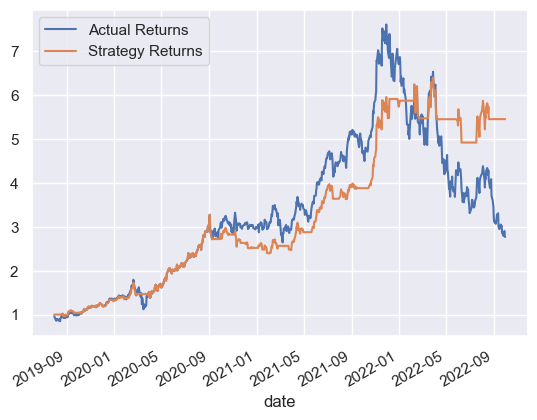

In [94]:
(1 + data_bt[['Actual Returns', 'Strategy Returns']]).cumprod().plot()

---
## Machine Learning

In [32]:
data_ml = data.shift().drop(columns=['Entry/Exit', 'trade_type', 'cost/proceeds']).dropna()
X = data_ml.drop(columns=['Signal'])
y = data_ml['Signal']
X.head()

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-07-31,43.237499,43.985001,43.092499,43.862499,19777200.0,43.57480,71.414320,0.473948,43.670001,43.741926,42.009000,42.219236,41.780075,40.862796,41.631425,41.017802,-0.001196,45.102412,33.197388,3.114858e+06
2019-08-01,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,42.090125,42.215500,41.825275,40.889356,41.548412,41.031155,-0.055636,45.237460,33.232040,-6.047170e+07
2019-08-02,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,42.117250,42.121642,41.834725,40.896223,41.446387,41.033436,-0.048795,45.311452,33.256648,-4.001517e+07
2019-08-05,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,42.129251,41.947915,41.831400,40.884159,41.353650,41.025007,-0.079283,45.352359,33.305641,-3.994340e+07
2019-08-06,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,42.049000,41.543113,41.786825,40.819971,41.234850,40.986948,-0.137456,45.345277,33.347423,-1.531807e+08


In [33]:
# Review y value counts
y.value_counts()

1.0    476
0.0    324
Name: Signal, dtype: int64

In [34]:
# Split train - test data
split_ratio=0.8
train_size = int(round(split_ratio * X.shape[0]))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 20) (640,)
(160, 20) (160,)


In [35]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


### Use the 'XGBoost' classifier model to fit the training data and make predictions based on the testing data.

In [36]:
# Instantiate XGB classifier model instance
model = xgb.XGBClassifier()
 
# Fit the model to the data using the training data
model = model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [37]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report = classification_report(y_test, pred)

# Print the classification report
print(testing_report)

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       104
         1.0       0.98      0.91      0.94        56

    accuracy                           0.96       160
   macro avg       0.97      0.95      0.96       160
weighted avg       0.96      0.96      0.96       160



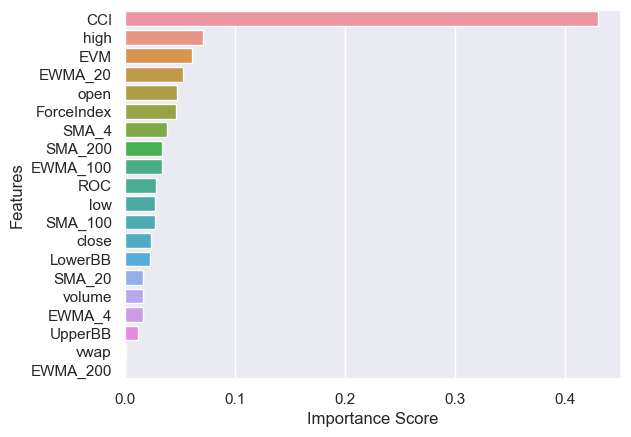

In [38]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()

In [44]:
pickle.dump(model, open('./Resources/NVDA_ml_model.pkl', 'wb'))

---
## Machine Learning - Backtest

In [58]:
# Filter the date index and close columns
data_bt = data.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
data_bt["Actual Returns"] = data_bt["close"].pct_change()

# Drop all NaN values from the DataFrame
data_bt = data_bt.dropna()

# Review the DataFrame
display(data_bt.head())
display(data_bt.tail())

,close,Actual Returns
date,,
2019-07-31,42.180000,-0.038358
2019-08-01,41.229999,-0.022523
2019-08-02,40.297501,-0.022617
2019-08-05,37.697498,-0.064520
2019-08-06,38.087502,0.010346


,close,Actual Returns
date,,
2022-09-26,122.279999,-0.023011
2022-09-27,124.130000,0.015129
2022-09-28,127.360000,0.026021
2022-09-29,122.200000,-0.040515
2022-09-30,121.390000,-0.006628


In [85]:
X_scaled = X_scaler.transform(X)
pred_bt = model.predict(X_scaled)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = pred_bt

# Add Entry/Exit signal to the DataFrame
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()
predictions_df = predictions_df.dropna()

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = data_bt['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Actual Returns'] * predictions_df['Predicted'])

# Review the DataFrame
predictions_df


,Predicted,Entry/Exit,Actual Returns,Strategy Returns
date,,,,
2019-08-01,0,0.0,-0.022523,-0.0
2019-08-02,0,0.0,-0.022617,-0.0
2019-08-05,0,0.0,-0.064520,-0.0
2019-08-06,0,0.0,0.010346,0.0
2019-08-07,0,0.0,0.010108,0.0
...,...,...,...,...
2022-09-26,0,0.0,-0.023011,-0.0
2022-09-27,0,0.0,0.015129,0.0
2022-09-28,0,0.0,0.026021,0.0


In [86]:
# store file for checking trades using Excel
filepath = Path('./Resources/data_pred.csv')
predictions_df.to_csv(filepath)

,Predicted,Entry/Exit,Actual Returns,Strategy Returns
date,,,,
2019-08-01,0,0.0,-0.022523,-0.0
2019-08-02,0,0.0,-0.022617,-0.0
2019-08-05,0,0.0,-0.064520,-0.0
2019-08-06,0,0.0,0.010346,0.0
2019-08-07,0,0.0,0.010108,0.0
...,...,...,...,...
2022-09-26,0,0.0,-0.023011,-0.0
2022-09-27,0,0.0,0.015129,0.0
2022-09-28,0,0.0,0.026021,0.0


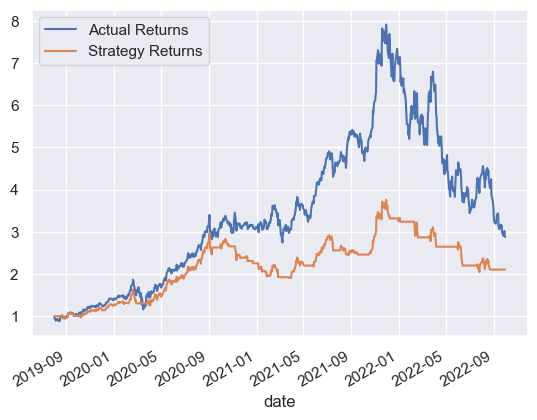

In [87]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()

In [84]:
# store file for checking trades using Excel
filepath = Path('./Resources/data_pred.csv')
predictions_df.to_csv(filepath)